## Summary
----

We transform UMAP from a black box into a glass box. By fitting the mapping with a type of deep network, we calculate the contributions of input features to  every point as a linear weight, revealing the heretofore hidden logic of UMAP embeddings.

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

UMAP is a ubiquitous tool for low-dimensional visualization of high-dimensional datasets. UMAP learns a low-dimensional mapping from nearest-neighbor graph structures of datasets, often producing visually interpretable  clusters of data that match known labels (e.g., cell type). This is possible because the  mapping is highly nonlinear with respect to the input features values, giving it the expressive power needed to form distinct clusters. While the learned  relationship between the input features and the embedding positions is often useful, the same nonlinearity that enables clean clusters also makes it difficult to directly interpret the mapping in terms of the input features. 

Here, we show how to enable interpretation of the mapping through an alternative implementation of the parametric UMAP algorithm which learns the embedding with a deep network that is locally linear (but globally nonlinear) with respect to the input features. This “glass-box” approach provides a set of exact feature contributions as linear weights that determine the embedding of each data point. By computing the exact feature contribution for each point in a dataset, we can directly quantify which features are responsible for forming each cluster. We explore the feature contributions for a gene expression dataset from the glass-box augmentation of UMAP and compare them with features found by differential expression.


## Introduction
----

UMAP (Uniform Manifold Approximation and Projection) is a powerful tool for nonlinear dimensionality reduction. Despite some critical appraisals focused on the use of relative distances over the nonlinear embedding space to generate hypotheses, as well as the “black box” nature of the nonlinear mapping, UMAP remains popular in many fields. Here we present an augmentation to conventional UMAP analysis that generates exact feature attributions for each point in the dataset.

Principal components analysis (PCA) is another popular method for dimensionality reduction which finds an alternative linear representation of a dataset by determining a orthogonal directions of maximal variance. Since the principal components that can be used for dimensionality reduction are the linear weights on input feature, this approach was considered to be directly interpretable in feature space.

The recent popularity of the nonlinear UMAP embedding, which is excellent at forming distinctive clusters, came at the cost of interpretable embeddings. Nonlinear methods are generally thought to be black boxes, although there are a range of post-hoc feature attribution methods that provide some measure of interpretability (like differential expression applied for scRNAseq data). UMAP is ubiquitous because of its ability to successfully cluster classes for complex datasets in an unsupervised fashion, in spite of its black-box nature.

UMAP generates distinct clusters as a black box, while PCA provides (sometimes less-distinct) clusters for complex datasets, but also exact feature contributions. What if we could have the best of both approaches? A technique for interpreting nonlinear deep networks [Wang et al., 2016; Mohan et al., 2019] provides the key for bringing exact feature interpretability to UMAP. 


## Method
----
At a high level, UMAP emUMAP embeds high-dimensional data into low dimensions by building a nearest-neighbor graph in the original space and learning an embedding in the low-dimensional space that preserves the nearest-neighbor graph according to a loss function.

The extension to a “parametric” form of UMAP (McInnes, 2018 NC), where the low dimensional mapping is learned by a deep network, is a valuable generalization of the embedding approach where new data points can be embedded using the same function,which was not possible with the original version of UMAP. The parametric network is trained using the same loss function (TO DO: show loss function) as the non-parametric model, so this deep network function captures the same relationships as the original non-parametric implementation.

The deep network approach for parametric UMAP is conventionally considered to be somewhat opaque to feature attribution. However, by taking advantage of a growing body of work in this area, we can implement a deep network with a particular architecture that allows us to measure the exact contributions of each input feature.

In the “Extended Data Jacobian Matrix” [Wang et al., 2016] and “Bias-free deep networks…” [Mohan et al., 2019], it is shown that deep networks with zero bias linear layers and certain types of activation functions have exactly equivalent linear representations. Even though these networks are globally nonlinear, which is why deep networks can learn such complex mappings, they are also locally linear for a particular input. These networks fall into the category of homogeneous functions of order 1, which based on Euler’s theorem means a function \\(y(x)\\) has an equivalent representation with the Jacobian \\(J\\) which varies as a function of \\(x\\):

$$y(x) = J(x) \cdot x$$

This is both linear and exact, although the Jacobian must be numerically computed for each input. Linear representations offer a straightforward approach to understanding what the network is doing. At the very least, they are more interpretable than locally nonlinear networks (which includes any deep network with nonzero bias terms in its linear layers).

In today’s GPU rich world, it is straightforward to compute these linear feature contributions for every point in a dataset. These types of deep networks for genomics data are locally linear, and from an interpretability perspective they are effectively globally linear. We easily can perform an exhaustive local analysis, where we compute the Jacobian (via autograd) for every point in a dataset. With globally linear systems, there is only one set of feature weights to analyze, but with locally linear systems, there are as many Jacobians (feature weights) as data points, this becomes an additional step in the analysis. 

The exactness of this Jacobian approach is the centerpiece of its appeal. This local analysis is similar to SHAP, LIME and GradCAM, but those are all approximations which could be completely incorrect for the actual nonlinear representation. The Jacobian of a zero-bias ReLU deep network simply weights each feature, quantifying how the globally nonlinear network uses it in the output.

In our case, we apply these deep networks with linear equivalents that exactly reconstruct the output to UMAP. In many papers, UMAP is presented as an interesting representation of data, but is not used much beyond that. In the conventional approach to defining cell type clusters in the embedding space, differential expression is run on various clusters to show what genes are differentially expressed on average (which is a completely different calculation than anything UMAP has done), and cell types are assigned based on those genes. In contrast, with fully interpretable “glass-box” networks, we can compute the exact contribution of each gene to the position of every single cell shown in the UMAP embedding space. Now, the exact gene feature contributions can be directly pulled from the nonlinear UMAP function, instead of from differential expression acting as a proxy for what UMAP learned. Additionally, the Jacobian approach works equally as well for image or protein embedding representations as scRNAseq data, where tools like differential expression are not available.

Beyond the feature attributions for each point, these can be aggregated over categories (like Leiden cluster or cell type) in order to generate hypotheses about the gene features connected to higher-level phenotypes represented in the dataset. This can be done in a straightforward manner by conditioning the feature attribution calculations on a given cell type (or Leiden cluster) and measuring summary statistics, like the mean or the SVD of the feature contributions.

The use of glass box deep networks for UMAP therefore provides clarity into what the embedding function has actually learned.


In [16]:
#| output-toggle: true
#| output-location: hide
print("This output should be hidden but togglable.")

This output should be hidden but togglable.


In [ ]:
# | output: false
# | code-fold: true
#autoreload
%load_ext autoreload
%autoreload 2

In [3]:
# | code-fold: true
# | output: false
#install tools
!uv pip install --system scanpy igraph leidenalg matplotlib pytorch_lightning arcadia_pycolor umap_pytorch adjustText

Using Python 3.12.12 environment at: /usr
Resolved 89 packages in 1.30s                                        
Prepared 21 packages in 1.20s                                            
Uninstalled 1 package in 527ms
Installed 21 packages in 54ms                               
 + adjusttext==1.3.0
 + anndata==0.12.3
 + arcadia-pycolor==0.6.5
 + array-api-compat==1.12.0
 + colorspacious==1.1.2
 + crc32c==2.7.1.post0
 + donfig==0.8.1.post1
 + igraph==0.11.9
 + kaleido==0.2.1
 + legacy-api-wrap==1.4.1
 + leidenalg==0.10.2
 + lightning-utilities==0.15.2
 + numcodecs==0.16.3
 - plotly==5.24.1
 + plotly==6.3.1
 + pytorch-lightning==2.5.5
 + scanpy==1.11.4
 + session-info2==0.2.3
 + texttable==1.7.0
 + torchmetrics==1.8.2
 + umap-pytorch==0.0.7
 + zarr==3.1.3


In [4]:
# | code-fold: true
# | output: false
#load tools
import arcadia_pycolor as apc
import matplotlib as mpl

from src.analysis.preprocess import *
from src.analysis.utils_jacobian import *
from src.analysis.networks import * #deepReLUNet, deepSiLUNet, deepBilinearNet, BatchNormDetached

from umap_pytorch import PUMAP
import torch.nn.functional as F


/usr/local/lib/python3.12/dist-packages/colorspacious/comparison.py:11: SyntaxWarning: invalid escape sequence '\D'
  """Computes the :math:`\Delta E` distance between pairs of colors.
/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij

In [5]:
# | code-fold: true
# -*- coding: utf-8 -*-
'''
Script for single-cell analysis using Scanpy.

This script processes CITE-seq data of bone marrow mononuclear cells (BMMCs)
by performing quality control, normalization, dimensionality reduction,
and clustering.
'''

# Core libraries
import os
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

# --- Function Definitions ---

def download_and_load_data(url, filename):
    '''
    Downloads, unzips, and loads the AnnData file.

    Args:
        url (str): The URL to the compressed .h5ad file.
        known_hash (str): The expected SHA256 hash of the file for validation.

    Returns:
        ad.AnnData: The loaded AnnData object.
    '''
    print("Downloading and loading data...")
    
    # # Download the compressed file from the GEO FTP server
    import subprocess
    if not os.path.isfile(filename):
        subprocess.run(["wget", url, "--no-verbose"])

        subprocess.run(["gunzip", filename])

def initial_preprocessing(adata):
    '''
    Performs initial preprocessing steps like ensuring unique names and
    annotating gene types.

    Args:
        adata (ad.AnnData): The AnnData object.

    Returns:
        ad.AnnData: The preprocessed AnnData object.
    '''
    print("Running initial preprocessing...")
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # Annotate mitochondrial, ribosomal, and hemoglobin genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    print("Initial preprocessing complete.")
    return adata


def run_quality_control(adata, perform_qc=True, show_plot=False):
    '''
    Calculates and visualizes quality control metrics.

    Args:
        adata (ad.AnnData): The AnnData object.
        perform_qc (bool): If True, calculates and plots QC metrics.

    Returns:
        ad.AnnData: The AnnData object, possibly with new QC metrics.
    '''
    if not perform_qc:
        print("Skipping quality control step.")
        return adata

    print("Running quality control...")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
    )
    if show_plot:
        # Visualize QC metrics
        sc.pl.violin(
            adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
            jitter=0.4,
            multi_panel=True,
        )
        sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    print("Quality control complete.")
    return adata


def filter_and_detect_doublets(adata, run_scrublet=False):
    '''
    Filters cells/genes and runs doublet detection.

    Args:
        adata (ad.AnnData): The AnnData object.
        run_scrublet (bool): If True, runs Scrublet for doublet detection.

    Returns:
        ad.AnnData: The filtered AnnData object.
    '''
    print("Filtering data and detecting doublets...")
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=20)#3)

    # Optional doublet detection
    if run_scrublet:
        print("🧬 Running Scrublet for doublet detection...")
        sc.pp.scrublet(adata, batch_key="sample")
    
    print("Filtering and doublet detection complete.")
    return adata


def normalize_and_select_features(adata, show_plot=False):
    '''
    Normalizes data and selects highly variable genes.

    Args:
        adata (ad.AnnData): The AnnData object.

    Returns:
        ad.AnnData: The processed AnnData object.
    '''
    print("Normalizing data and selecting features...")
    # Save raw counts
    adata.layers["counts"] = adata.X.copy()
    # Normalize and log-transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    # Find and plot highly variable genes
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="Samplename")
    if show_plot:
        sc.pl.highly_variable_genes(adata)
    print("Normalization and feature selection complete.")
    return adata


def run_dimensionality_reduction(adata,n_pcs=50, show_plot=False, use_highly_variable=True):
    '''
    Performs PCA and visualizes the results.

    Args:
        adata (ad.AnnData): The AnnData object.

    Returns:
        ad.AnnData: The AnnData object with PCA results.
    '''
    print("Reducing dimensionality with PCA...")
    sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=use_highly_variable)

    # Visualize PCA results
    if show_plot:
        sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True)
        sc.pl.pca(
            adata,
            color=["cell_type"],#, "pct_counts_mt"],
            dimensions=[(0, 1)],#, (2, 3)],
            ncols=1,
        )
    print("PCA complete.")
    return adata


def compute_umap_embedding_and_clusters(adata, show_plot=False):
    '''
    Computes nearest neighbors, UMAP embedding, and Leiden clustering.

    Args:
        adata (ad.AnnData): The AnnData object.

    Returns:
        ad.AnnData: The AnnData object with UMAP and clustering results.
    '''
    print("Computing neighborhood graph, UMAP, and clusters...")
    # sc.pp.neighbors(adata)

    sc.pp.neighbors(adata, n_neighbors=15, n_pcs = 50, use_rep='X_pca')
    sc.tl.umap(adata, init_pos='random')
    # if show_plot:
    #     sc.pl.umap(adata, color="cell_type", size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
    print("Embedding and clustering complete.")
    return adata


def visualize_final_results(adata, perform_qc_reassessment=True):
    '''
    Generates final UMAP visualizations for cell types, clusters, and QC metrics.

    Args:
        adata (ad.AnnData): The final AnnData object.
        perform_qc_reassessment (bool): If True, plots UMAPs with QC metrics.
    '''
    print("Generating final visualizations...")
    # Visualize cell types and clusters on UMAP
    sc.pl.umap(adata, color="cell_type", size=2)
    sc.pl.umap(adata, color=["leiden"])

    # Re-assess QC metrics on the UMAP
    if perform_qc_reassessment:
        sc.pl.umap(
            adata,
            color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
            wspace=0.5,
            ncols=2,
        )
    print("🎉 Analysis visualization complete!")

def download_bone_marrow_dataset(DOWNLOAD_DATA = True,
                            data_url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz",                                
                            h5ad_filename = "GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz"
    ):
    '''
    Main function to run the single-cell analysis workflow.
    '''
    # --- Parameters ---
    # Set to False to skip downloading if the file already exists and is unzipped
    # DOWNLOAD_DATA = True
    # # NOTE: The original script had this flag but didn't use it to load separate samples.

    if DOWNLOAD_DATA:
        adata = download_and_load_data(data_url, h5ad_filename)
    else:
        # Assumes the file is already downloaded and unzipped in the current directory
        adata = ad.read_h5ad(h5ad_filename)
    
def preprocess_bone_marrow_dataset(adata = None, full_preprocess=True, FILTER_BY_SAMPLES = False, QUALITY_CONTROL = True,
                                   h5ad_filename = "GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad",n_pcs=50,show_plot=False
    ):
    '''
    Main function to run the single-cell analysis workflow.
    '''
    # --- Parameters ---
    # FILTER_BY_SAMPLES = False
    # # Set to False to skip the optional QC metric calculation and plotting
    # QUALITY_CONTROL = False
    if adata is None:
        adata = ad.read_h5ad(h5ad_filename)
    adata = initial_preprocessing(adata)
    if full_preprocess:
        adata = run_quality_control(adata, perform_qc=QUALITY_CONTROL)
        adata = filter_and_detect_doublets(adata, run_scrublet=FILTER_BY_SAMPLES)
        adata = normalize_and_select_features(adata)
        
        adata = run_dimensionality_reduction(adata,n_pcs=n_pcs,show_plot=show_plot)
    return adata

def umap_original(adata, QUALITY_CONTROL = True,
    ):
    '''
    Main function to run the single-cell analysis workflow.
    '''
    # --- Parameters ---
    # FILTER_BY_SAMPLES = False
    # # Set to False to skip the optional QC metric calculation and plotting
    # QUALITY_CONTROL = False

    adata = compute_umap_embedding_and_clusters(adata)
    visualize_final_results(adata, perform_qc_reassessment=QUALITY_CONTROL)

# | code-fold: true
#dataset and preprocessing
def init_data(donors=True,t_cells=False,n_pcs=50):
    '''
    Filter dataset by most common cell types or by T cells only.
    '''
    if t_cells:
        adata = preprocess_bone_marrow_dataset(n_pcs=n_pcs, full_preprocess=False)
        adata_subset1 = adata[adata.obs['cell_type'] == 'CD4+ T activated', :]
        adata_subset3 = adata[adata.obs['cell_type'] == 'CD4+ T naive', :]

        adata = ad.concat([adata_subset1,adata_subset3], label="T_cell_type")

    elif donors:
        adata = preprocess_bone_marrow_dataset(n_pcs=n_pcs, full_preprocess=False)
        adata_subset1 = adata[adata.obs['Samplename'] == 'site1_donor1_cite', :]
        adata_subset3 = adata[adata.obs['Samplename'] == 'site1_donor3_cite', :]

        adata = ad.concat([adata_subset1,adata_subset3], label="donors")
        adata.obs_names_make_unique()

        # mask = adata.obs.cell_type.isin(adata.obs.cell_type.value_counts()[:12].index.values)
        # adata = adata[mask,:]
        adata = preprocess_bone_marrow_dataset(adata,n_pcs=n_pcs, full_preprocess=True)
        mask = adata.obs.cell_type.isin(adata.obs.cell_type.value_counts()[:12].index.values)
        adata = adata[mask,:]
    else:
        adata = preprocess_bone_marrow_dataset(adata,n_pcs=n_pcs, full_preprocess=True)
    return adata

## Loading the data and tools
----
For an example dataset, we will use the human bone marrow gene expression data of Luecken, et. al., (2021), which is the example dataset now included in ScanPy. 

Luecken, M. D., Burkhardt, D. B., Cannoodt, R., Lance, C., Agrawal, A., Aliee, H., ... & Bloom, J. M. (2021, August). A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. In Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2).

In [6]:
download_bone_marrow_dataset()

We will also load a set of tools including the "UMAP PyTorch" toolbox in addition to ScanPy, and define a custom PyTorch network to learn an embedding.

In [7]:
# | code-fold: true
#parametric UMAP deep network in PyTorch
from torch import nn
class deepReLUNet(nn.Module):
    # A deep network using PReLU activation.
    def __init__(self, input_size: int = 50, hidden_size: int = 256, output_size: int = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), 
            nn.Linear(hidden_size, output_size, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the PReLU network.
        return self.model(x)
class LayerNormDetached(nn.Module):
    '''
    A LayerNorm implementation where the variance calculation is detached from the
    computation graph during evaluation, potentially stabilizing training.
    '''
    def __init__(self, emb_dim: int):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''Forward pass for LayerNormDetached.'''
        mean = x.mean(dim=-1, keepdim=True)
        # Detach variance calculation during evaluation
        if not self.training:
            var = x.clone().detach().var(dim=-1, keepdim=True, unbiased=False)
        else:
            var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - mean) / torch.sqrt(var)
        return self.scale * norm_x


## Fitting the data with the UMAP PyTorch toolbox

We use the UMAP PyTorch toolbox to learn an embedding. This fit uses the same loss as the non-parametric version of UMAP. We found that setting the "repulsion strength" parameter to 3.0 (up from 1.0) helped the embeddings learned in PyTorch to better match the embeddings from non-parametric UMAP fits. This parameter effectively controls how far clusters in the embedding space move away from each other, and higher values keep the clusters closer together.

In [8]:
# | code-fold: true
#parametric UMAP fit
def fit(adata, n_pcs=50, epochs=64, random_state=12):
    train_dataset, adata_mean_zero = prepare_data(adata, pca_components=n_pcs)#,  pca_start=1)
    network = deepReLUNet(input_size=n_pcs,hidden_size=1024+128) # Replace with your model instantiation
    # decoder = deepReLUNetDecoder(input_size=n_pcs,hidden_size=1024+128) # Replace with your model instantiation
    # repulsion 3.0
    pumap = PUMAP(
        encoder=network,           # nn.Module, None for default
        decoder=None,#decoder,           # nn.Module, True for default, None for encoder only
        n_neighbors=15,#50,
        min_dist=0.3,#0.24,#0.3,#0.75,
        metric="euclidean",
        # n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=random_state,
        lr=1e-4,
        epochs=epochs,
        batch_size=256*8,
        num_workers=8,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
    )

    if fit:
        pumap.fit(train_dataset.squeeze())#

    return train_dataset, pumap, adata_mean_zero

The preprocessing pipeline follows the standard procedure for the dataset in [the ScanPy clustering tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html). We take the extra step of filtering out the less common cell types to simplify visualizations and keep only the top 12.

In [9]:
adata = init_data(n_pcs=50)
adata

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running initial preprocessing...
Initial preprocessing complete.
Running initial preprocessing...
Initial preprocessing complete.
Running quality control...
Quality control complete.
Filtering data and detecting doublets...
Filtering and doublet detection complete.
Normalizing data and selecting features...
Normalization and feature selection complete.
Reducing dimensionality with PCA...


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


PCA complete.


View of AnnData object with n_obs × n_vars = 9068 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'donors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_coun

We carry out several independent UMAP fits to the data starting at different random initializations in order to generate error bars for the feature contributions.

In [10]:
# from src.analysis.networks import * #deepReLUNet, deepSiLUNet, deepBilinearNet, BatchNormDetached

In [11]:
# | code-fold: true
# | output: false
#fit UMAP with 8 different random intializations
# from umap_pytorch import PUMAP

from src.analysis.utils import *

num_fits=8
pumap_all = []
for ii in range(num_fits):
    train_dataset, pumapi, adata_mean_zero = fit(adata, n_pcs=50, epochs=1, random_state=3*ii)
    # train_dataset, pumapi, adata_mean_zero = fit(adata, n_pcs=50, epochs=72, random_state=3*ii)
    pumap_all.append(pumapi)

Preparing data for training...


/content/drive/MyDrive/colab/glass-box-umap/src/analysis/utils_jacobian.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  train_dataset = torch.tensor([adata.obsm["X_pca"][:, pca_start:pca_components]], dtype=torch.float32)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:18:21 2025 Building RP forest with 10 trees
Thu Oct 16 17:18:25 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:03 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:03 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:07 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:07 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:10 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:10 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:14 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:14 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:18 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:18 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:23 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:23 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Preparing data for training...


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Data prepared with training shape: torch.Size([1, 9068, 50])
Thu Oct 16 17:19:27 2025 Building RP forest with 10 trees
Thu Oct 16 17:19:27 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [12]:

from src.analysis.utils_jacobian import *
num_fits=8
for ii in range(num_fits):
    # train_dataset, pumapi, adata_mean_zero = fit(adata, n_pcs=50, epochs=72, random_state=3*ii)
    # pumap_all[ii]
    # torch.save(pumap_all[ii].model.state_dict(), 'models_1002/umap_'+str(ii)+'.pth')
    pumap_all[ii].model.load_state_dict(torch.load('models_1002/umap_'+str(ii)+'.pth'))

## UMAP of gene expression data

Here we show the embedding from the non-parametric UMAP from ScanPy.

In [15]:
# from matplotlib import font_manager as fm, pyplot as plt

# # Pick up any fonts in the current directory.
# # If you do end up downloading the fonts to /usr/share/fonts/truetype,
# # change this to: fm.findSystemFonts()
# font_files = fm.findSystemFonts('/colab/glass-box-umap/Suisse Int_l/')

# # Go through and add each to Matplotlib's font cache.
# for font_file in font_files:
#     # print(font_file)
#     fm.fontManager.addfont(font_file)

# # Use your new font on all your plots.
# # plt.rc('font', family='Open Sans')

/usr/local/lib/python3.12/dist-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


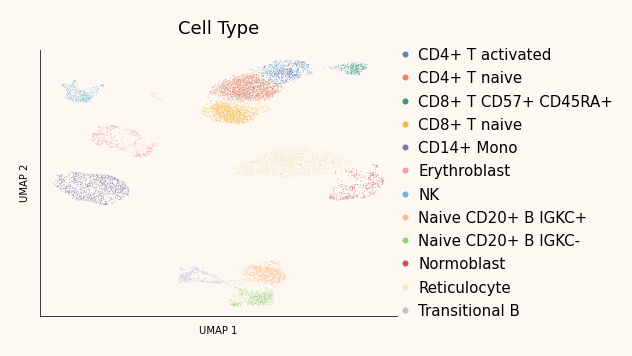

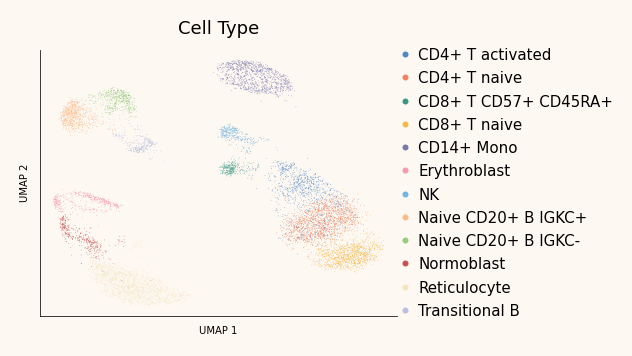

In [21]:
# | code-fold: true
# | label: fig-umap-original
# | layout-ncol: 2
# | fig-cap: "The conventional ScanPy UMAP and the PyTorch network UMAP. While they are not exactly the same, note the overall similarities. It is also possible to directly fit the embedding learned by the conventional UMAP algorithm, but here we show a fit with the PyTorch method to demonstrate how they find similar embeddings."
# | fig-subcap:
# |   - "The conventional ScanPy UMAP embedding."
# |   - "The PyTorch network UMAP embedding."


apc.mpl.setup()

#embedding plot
with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs = 50, use_rep='X_pca')
    sc.tl.umap(adata, init_pos='random', random_state=13)
    ax=sc.pl.umap(adata, color="cell_type", size=2, palette=list(apc.palettes.primary), show=False)
    ax.set_xlabel("UMAP 1", fontsize=10)
    ax.set_ylabel("UMAP 2", fontsize=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("Cell Type")
    # ax.set_aspect('square')
    plt.show()

#plot UMAP with scanpy matplotlib
with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    for ii in range(num_fits-1,num_fits):
        embedding = pumap_all[ii].transform(train_dataset.squeeze())
        adata.obsm['X_umap'] = embedding#encoder.model.encoder(train_dataset.squeeze()).squeeze().detach().cpu().numpy()
        # sc.pl.umap(adata, use_raw=False, color='cell_type',size=2,cmap = (apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap())
        # plt.show()

        ax =sc.pl.umap(adata, use_raw=False, color='cell_type',size=2, palette = list(apc.palettes.primary), show=False)

        # Modify the axes   
        ax.tick_params(axis='both', which='both')
        # ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True,
        #             length=4, width=1, colors='black', labelsize=8)
        # ax.tick_params(axis='y', which='both', left=True, labelleft=True,
        #             length=4, width=1, colors='black', labelsize=8)

        # 3. Add axis labels (optional, but good practice for clarity)
        ax.set_xlabel("UMAP 1", fontsize=10)
        ax.set_ylabel("UMAP 2", fontsize=10)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title("Cell Type")
        # ax.set_aspect('square')
        # 4. Show the plot
        plt.show()
        # Display the plot
        # plt.show()



## Exact decomposition of features

The Jacobians are computed for each input over the independent fits. This takes a bit of time: about two minutes per fit on a T4 GPU (on the order of the time spent fitting the model).

In [14]:
# | code-fold: true
#compute features for each UMAP fit
from src.analysis.utils_jacobian import compute_gene_space_jacobian

adf = adata.to_df()
adfmz = adf.values - adf.mean(axis=0).values

jacobxall_all, jacobian_all = [],[]
for ii in range(num_fits):
    jacobxall, jacobian = compute_gene_space_jacobian(pumap_all[ii].encoder, adata, train_dataset, adfmz, return_jacobian=True)#, jacobian_batch_size=40)#config["jacobian_batch_size"])
    jacobxall_all.append(jacobxall)
    jacobian_all.append(jacobian)

Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.


We can validate that the Jacobian reconstructs the embedding network output.

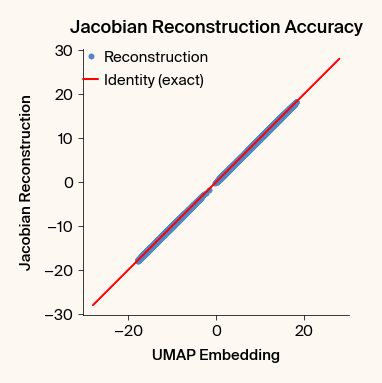

In [84]:
# | code-fold: true
# | label: fig-reconstruction-validation
# | fig-align: center
# | layout-ncol: 1
# | fig-cap: "To validate that the Jacobian reconstructs the UMAP encoder network output, we plot the embedding values against their Jacobian reconstructions and see that they fall on the identity line."

#plot example reconstruction to validate Jacobian
pcaoutfull = np.einsum('ijk,ik->ijk',np.array(jacobian),train_dataset.squeeze().detach().cpu().numpy())
pcaout = np.einsum('ijk,ik->ij',np.array(jacobian),train_dataset.squeeze().detach().cpu().numpy())
with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    ax=plt.figure()
    plt.scatter(embedding[:,0],pcaout[:,0])
    plt.plot([-28,28],[-28,28],'r',linewidth=2)
    plt.xlabel('UMAP Embedding')
    plt.ylabel('Jacobian Reconstruction')
    plt.title('Jacobian Reconstruction Accuracy')
    plt.legend(["Reconstruction", "Identity (exact)"])
    # plt.grid()
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    
    plt.axis('square')

## UMAP PyTorch with Feature Labels
----
We can visualize the embedding and add the top gene contributors to the embedding position as information in the hovertip. 
As an alternative visualization, we can color the embedding by the largest gene contributor. In some cases, a given cell type label will have different regions where different genes make the largest contribution, like for Reticulocytes, which have several sub regions where the strongest contributors are HBD and HBA2, but the sub region with HBD as the largest gene contributor also extends to the neighboring Normoblast cluster. The UMAP embedding is placing these points near each other because the HBD activity is similar (and correlations with other features are distinctive).

In [22]:
# | code-fold: true
#plotly UMAP embedding build dataframe
import plotly.express as px
import arcadia_pycolor as apc

# Call the `setup` function once, at the beginning of a notebook or script.
apc.plotly.setup()

import plotly.graph_objects as go
import plotly.express as px

import plotly.colors as pcolors
cellTypes=np.array(adata.obs.cell_type)
dfdimred=pd.DataFrame(np.array([embedding[:,0].astype('float'),embedding[:,1].astype('float'),cellTypes]).T,
                     columns = ['dim1','dim2','celltype'])

dfdimred.dim1=dfdimred.dim1.astype('float')
dfdimred.dim2=dfdimred.dim2.astype('float')

dfdimred
genes = adata.var.index.values
genedist = (jacobxall[:,0,:]**2+jacobxall[:,1,:]**2)#.#shape
geneindsort = [genes[np.argsort(genedist[ii,:])[::-1][:8]] for ii in range(genedist.shape[0])]
genemax = adata.to_df().abs().idxmax(axis=1)#.values#.shape
# jacobxall
genecoords = [jacobxall[ii,:,np.argsort(genedist[ii,:])[::-1][:8]] for ii in range(genedist.shape[0])]

genedf = pd.DataFrame(geneindsort,columns=["gene_"+str(ii) for ii in range(8)])
# coordsx = pd.DataFrame(np.array(genecoords)[:,:,0],columns=["x_"+str(ii) for ii in range(8)])
# coordsy = pd.DataFrame(np.array(genecoords)[:,:,0],columns=["y_"+str(ii) for ii in range(8)])
dfdimred=pd.concat([dfdimred,genedf],axis=1)
dfdimred=pd.concat([dfdimred,pd.Series(genemax.values)],axis=1)


# dfdimred=pd.concat([dfdimred,coordsx],axis=1)
# dfdimred=pd.concat([dfdimred,coordsy],axis=1)
# cols = ['sexLabel','cellType'] # "GDP per Capita" & "Social Support"

# fig = go.Figure()
# col = 'celltype'
# cm = (apc.palettes.primary + apc.palettes.secondary)#.to_mpl_cmap()
# figpx = px.scatter(dfdimred.assign(Plot=col), x='dim1', y='dim2',title='Bone Marrow Gene Expression: Cell Type',
#           color=col,color_discrete_sequence=cm,#px.colors.qualitative.Light24,
#                     hover_data=["gene_"+str(ii) for ii in range(8)])#,size=0.01*np.ones(len(cellTypes)))
# # figpx.update_layout(legend = dict(font = dict(size = 12),itemwidth=30,itemsizing='constant'))
# #                      title='Deep autoencoder for 10X Mouse VMH neurons, test set, KNN acc = 80.1%')#
# figpx.update_layout(width=1400, height=1000, autosize=False)
# figpx.update_traces(marker_size = 5)
# # figpx.show()


In [23]:
# | code-fold: true
# | label: fig-umap-hover-top-genes
# | layout-ncol: 2
# | fig-cap: "The PyTorch UMAP embedding colored by cell type with top genes for each cell labeled in the hover tip."
#plotly UMAP embedding with data tags

apc.plotly.setup()
fig = go.Figure()
col = 'Cell Type'
dfdimred['UMAP 1']=dfdimred['dim1']
dfdimred['UMAP 2']=dfdimred['dim2']
dfdimred['Cell Type']=dfdimred['celltype']
cell_types_ordered = dfdimred.celltype.value_counts().index
cm = (apc.palettes.primary + apc.palettes.secondary)#.to_mpl_cmap()
hover_data = ["gene_"+str(ii) for ii in range(3)]
figpx = px.scatter(dfdimred.assign(Plot=col), x='UMAP 1', y='UMAP 2',title='Bone Marrow Gene Expression: Cell Type',
          color=col,color_discrete_sequence=cm,#px.colors.qualitative.Light24,
                    hover_data=hover_data, category_orders={col: cell_types_ordered})#,size=0.01*np.ones(len(cellTypes)))
# figpx.update_layout(legend = dict(font = dict(size = 12),itemwidth=30,itemsizing='constant'))
#                      title='Deep autoencoder for 10X Mouse VMH neurons, test set, KNN acc = 80.1%')#
figpx.update_layout(width=1000, height=1000, autosize=False)

figpx.update_traces(marker_size = 8)
fig.update_layout(
    legend=dict(
        itemsizing='constant' # Makes legend symbol size constant
    )
)
# Calculate the centroid coordinates for each cell type
centroids = dfdimred.groupby('Cell Type')[['dim1', 'dim2']].mean()

# Iterate over the centroids and add them as annotations to the figure
# for celltype, center in centroids.iterrows():
#     figpx.add_annotation(
#         x=center['dim1'],
#         y=center['dim2'],
#         text=f"<b>{celltype}</b>",  # Use the celltype name as the text
#         showarrow=False,
#         font=dict(
#             size=18,
#             color='black'
#         ),
#         align='center',
#         bgcolor='rgba(255, 255, 255, 0.4)', # Add a semi-transparent background
#         borderpad=4
#     )

apc.plotly.style_plot(figpx, monospaced_axes="all")
figpx.show()

In [24]:
# | code-fold: true
# | label: fig-umap-plot-genes
# | layout-ncol: 2
# | fig-cap: "The PyTorch UMAP embedding colored by top geen feature, showing that some cell types have regions with different top gene contributors, and some top gene contributors extend across type divisons."
#plotly UMAP embedding colored by top gene features
mask = dfdimred.gene_0.isin(dfdimred.gene_0.value_counts()[:16].index)
# print("fraction of data", sum(mask)/len(dfdimred))
fig = go.Figure()
col = 'Top Gene'
dfdimred['Top Gene']=dfdimred["gene_0"]
top_genes_ordered = dfdimred[mask].gene_0.value_counts().index.tolist()
    
hover_data = ["gene_"+str(ii) for ii in range(3)]
hover_data.append("Cell Type")
figpx = px.scatter(dfdimred[mask].assign(Plot=col), x='UMAP 1', y='UMAP 2',title='Bone Marrow Gene Expression: \nMost Common Top Gene Contributors, '+f"{sum(mask)/len(dfdimred):.2%}"+" of cells shown",
        #   color=col,color_discrete_sequence=pcolors.qualitative.Light24,#'cm,#,(apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap(),
          color=col,color_discrete_sequence=(apc.palettes.secondary+apc.palettes.primary) ,
                    hover_data=hover_data, category_orders={"gene_0": top_genes_ordered})#,size=0.01*np.ones(len(cellTypes)))
# figpx.update_layout(legend = dict(font = dict(size = 12),itemwidth=30,itemsizing='constant'))
#                      title='Deep autoencoder for 10X Mouse VMH neurons, test set, KNN acc = 80.1%')#
figpx.update_layout(width=1000, height=1000, autosize=False)
figpx.update_traces(marker_size = 8)

centroids = dfdimred[mask].groupby('gene_0')[['dim1', 'dim2']].mean()

# Iterate over the centroids and add them as annotations to the figure
for celltype, center in centroids.iterrows():
    figpx.add_annotation(
        x=center['dim1'],
        y=center['dim2'],
        text=f"<b>{celltype}</b>",  # Use the celltype name as the text
        showarrow=False,
        font=dict(
            size=18,
            color='black'
        ),
        align='center',
        bgcolor='rgba(255, 255, 255, 0.4)', # Add a semi-transparent background
        borderpad=4
    )
figpx.show()


### Feature labels by gene
----

We can also generate these plots on average over each class. With 8 separate UMAP fits at different random initializations, we provide the standard error of the normalized mean contribution of each feature. The feature contributions are normalized by the mean embedding distance of the class for a given fit, since in one fit a class could be class to the origin, and far away from the origin in another. 

Note that the largest feature contributors do not always point in the direction of the centroid. This gives rise to a gradient of contribution across a cluster. For example, in the reticulocyte cluster, cells embedded with a more negative UMAP 2 coordinate have higher contributions from HBD and HBM, while cells with a more negative UMAP 1 coordinate have higher HBA2, HBA1 and HBB contributions.


In [26]:
# | code-fold: true
#plot UMAP with gene features
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import arcadia_pycolor as apc
import matplotlib as mpl
from adjustText import adjust_text

from matplotlib.transforms import ScaledTranslation

def plot_feature_importance_by_cell_type(
    all_run_jacobians: np.ndarray,
    adata: ad.AnnData,
    embedding: np.ndarray,
    n_features_bars: int = 12,
    n_features_vectors: int = 5,
    cell_type_plot: list = list(np.arange(12))
) -> dict:
    
    # Analyzes and visualizes feature contributions for each cell type from UMAP Jacobians.

    # For each cell type, this function generates a two-panel plot:
    # 1. A UMAP embedding highlighting the cells and overlaying vectors for the top
    #    contributing genes, which originate from (0,0).
    # 2. A horizontal bar chart showing the top contributing genes, with error bars
    #    representing the SEM across multiple independent runs.

    # Args:
    #     all_run_jacobians (np.ndarray): Jacobians from multiple runs.
    #         Shape: (n_runs, n_cells, n_embedding_dims, n_genes).
    #     adata (ad.AnnData): The annotated data object.
    #     embedding (np.ndarray): The 2D UMAP embedding coordinates from one run.
    #         Shape: (n_cells, 2).
    #     n_features_bars (int, optional): Number of genes for the bar plot. Defaults to 12.
    #     n_features_vectors (int, optional): Number of gene vectors for the UMAP plot. Defaults to 5.

    # Returns:
    #     dict: A dictionary mapping each cell type to its top contributing genes.
    
    # --- Setup ---
    gene_names = adata.var_names.values
    cell_types = adata.obs["cell_type"].value_counts().index
    cell_type_codes = adata.obs["cell_type"].astype("category").cat.codes
    n_runs = all_run_jacobians.shape[0]
    
    top_genes_per_cell_type = {}
    mean_contributions_per_cell_type = {}
    cmap = (apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap()
    category_colors = [cmap(i) for i in range(len(cell_types))]

    color_map = {cell_type: cmap(i) for i, cell_type in enumerate(cell_types)}
    # Get all cell types as a simple list
    cell_type_list = adata.obs["cell_type"].tolist()

    # Map each cell type in the list to its color
    point_colors = np.array([color_map[cell_type] for cell_type in cell_type_list])

    ind_to_gene = {ii:kk for ii,kk in enumerate(adata.var.index.values)}
    # gene_to_ind = {kk:ii for ii,kk in enumerate(adata.var.index.values)}

    figlabels = [['A)','B)'], ['C)','D)'], ['E)','F)'], ['G)','H)'], ['I)','J)'], ['K)','L)'], ['M)','N)'], ['O)','P)'], ['Q)','R)'], ['S)','T)'], ['U)','V)'], ['W)','X)']]

    with mpl.rc_context({
        "figure.facecolor": apc.parchment,
        "axes.facecolor": apc.parchment,
    }):
        for i, cell_type in enumerate(cell_types[:]):
            if i in cell_type_plot:
                # print(f"\nAnalyzing cell type: {cell_type}")

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7),subplot_kw=dict(box_aspect=1))
                # fig, (ax1, ax2) = plt.subplot_mosaic([['a)', 'b)']], layout='constrained', figsize=(14, 7),subplot_kw=dict(box_aspect=1))
                # print(ax1)
                # for label, ax in axs.items():
                figlabelsi=figlabels[i]
                for axi,ax in enumerate([ax1, ax2]):
                    # Use ScaledTranslation to put the label
                    # - at the top left corner (axes fraction (0, 1)),
                    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
                    # i.e. just outside the axes.
                    ax.text(
                        0.0, 1.0, figlabelsi[axi], transform=(
                            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                        fontsize=18, va='bottom')#, fontfamily='serif')
                is_cell_type_mask = adata.obs["cell_type"] == cell_type

                # --- Plotting: UMAP Embedding ---
                ax1.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, cmap=cmap, s=2, alpha=0.1)
                ax1.scatter(
                    embedding[is_cell_type_mask, 0], embedding[is_cell_type_mask, 1],
                    c=[category_colors[i]], s=14, marker="o", label=cell_type
                )
                ax1.set_title(f"{cell_type}")
                ax1.set_xlabel("UMAP 1")
                ax1.set_ylabel("UMAP 2")
                ax1.grid(False)
                ax1.set_aspect('equal')

                ax1.spines['right'].set_visible(False)
                ax1.spines['left'].set_visible(True)
                ax1.spines['bottom'].set_visible(True)
                ax1.spines['top'].set_visible(False)
                ax1.legend()

                # --- Calculation: Feature Contributions & Statistics ---
                jacobians_for_cell_type = all_run_jacobians[:, is_cell_type_mask, :, :]
                
                mean_jacobian_vectors = np.mean(jacobians_for_cell_type[-1], axis=(0))

                magnitudes = np.sqrt(jacobians_for_cell_type[:, :, 0, :]**2 + jacobians_for_cell_type[:, :, 1, :]**2)
                run_mean_contributions = []
                for run_idx in range(n_runs):
                    run_mags = magnitudes[run_idx, :, :]
                    total_contribution_per_cell = np.sum(run_mags, axis=1)
                    norm_factor = np.mean(total_contribution_per_cell)
                    # norm_factor = np.mean(np.sum(run_mags, axis=1))
                    # norm_factor = np.linalg.norm(run_mags,axis=1)
                    normalized_run_mags = (run_mags.T / norm_factor).T
                    run_mean_contributions.append(np.mean(normalized_run_mags, axis=0))
                mean_contributions = np.mean(np.array(run_mean_contributions), axis=0)
                sem_contributions = np.std(np.array(run_mean_contributions), axis=0) / np.sqrt(n_runs)
                sorted_indices = np.argsort(mean_contributions)[::-1]

                # run_mean_contributions = np.array(run_mean_contributions)
                # print([run_mean_contributions[ii][sorted_indices[:4]] for ii in range(len(run_mean_contributions))])
                # for runi in run_mean_contributions:
                #     print([[runi[ii]] for ii in sorted_indices[:4]])

                # run_mean_contributions = np.array(run_mean_contributions)
                # for ii in sorted_indices[:4]:
                #     print(ind_to_gene[ii], run_mean_contributions[:,ii], np.mean(run_mean_contributions[:,ii]))#, np.std(run_mean_contributions[:,ii]))

                # --- Plotting: Feature Contribution Vectors on UMAP ---
                origin = [0, 0]
                top_vector_indices = sorted_indices[:n_features_vectors]
                
                # Calculate scaling factor to make vectors visible relative to the cluster's position
                cluster_centroid = np.mean(embedding[is_cell_type_mask], axis=0)
                distance_from_origin = np.linalg.norm(cluster_centroid)
                max_vector_mag = np.max(np.linalg.norm(mean_jacobian_vectors[:, top_vector_indices], axis=0))
                scale_factor = distance_from_origin / max_vector_mag if max_vector_mag > 0 else 1

                # # Plot individual gene vectors from the origin
                # for gene_idx in top_vector_indices:
                #     vec = mean_jacobian_vectors[:, gene_idx] * scale_factor
                #     ax1.arrow(
                #         origin[0], origin[1], vec[0], vec[1],
                #         color='k', head_width=0.3, length_includes_head=True
                #     )
                #     ax1.annotate(
                #         gene_names[gene_idx], (vec[0], vec[1]),
                #         fontsize=12, bbox=dict(boxstyle="round,pad=0.1", fc=apc.parchment, ec="none", alpha=0.7)
                #     )
                # This list will store all the text annotation objects
                texts = []

                # Plot individual gene vectors and create annotation objects

                # Define a color similar to parchment for the text box background
                parchment_color = '#FBF5E6' # A light beige color
                for gene_idx in top_vector_indices:
                    vec = mean_jacobian_vectors[:, gene_idx] * scale_factor
                    
                    # Plot arrow from origin to the vector's endpoint
                    ax1.arrow(
                        origin[0], origin[1], vec[0], vec[1],width=0.2,
                        color='k', head_width=0.6, length_includes_head=True,
                        zorder=3 # Ensure arrows are on top of scatter points
                    )
                    
                    # Create the annotation and add it to our list
                    # The text will be placed at the tip of the vector initially
                    annotation = ax1.annotate(
                        gene_names[gene_idx],
                        (vec[0], vec[1]),
                        fontsize=12,
                        bbox=dict(boxstyle="round,pad=0.2", fc=parchment_color, ec="none", alpha=0.8)
                    )
                    texts.append(annotation)
                # adjust_text will move the text labels to prevent overlapping.
                # The `arrowprops` argument will draw a line from the new text position
                # back to the original point (the arrowhead).
                adjust_text(texts, ax=ax1, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

                # --- Plotting: Feature Importance Bar Chart ---
                top_bar_indices = sorted_indices[:n_features_bars]
                top_genes = gene_names[top_bar_indices][::-1]
                top_means = mean_contributions[top_bar_indices][::-1]
                top_sems = sem_contributions[top_bar_indices][::-1]

                bars = ax2.barh(top_genes, top_means, xerr=top_sems, capsize=3, color=category_colors[i])
                # ax2.bar_label(bars[5:], labels=[f'{g}' for g in top_genes[5:]], padding=5)
                ax2.bar_label(bars, labels=[f'{g}' for g in top_genes[:]], padding=5)#, fontweight='bold')
                ax2.tick_params(axis='y', left=False, labelleft=False)
                ax2.set_xlabel("Normalized feature contribution (mean ± SEM)")
                ax2.set_title(f"Top gene contributions for '{cell_type}'")
                ax2.spines['right'].set_visible(False)
                ax2.spines['top'].set_visible(False)
                ax2.grid(False)
                
                # --- Finalize and Store Results ---
                plt.tight_layout()
                plt.show()
                
                mean_contributions_per_cell_type[cell_type] = mean_contributions
                top_genes_per_cell_type[cell_type] = gene_names[sorted_indices[:n_features_bars]].tolist()

    return top_genes_per_cell_type, mean_contributions_per_cell_type


/tmp/ipython-input-2049284779.py:89: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



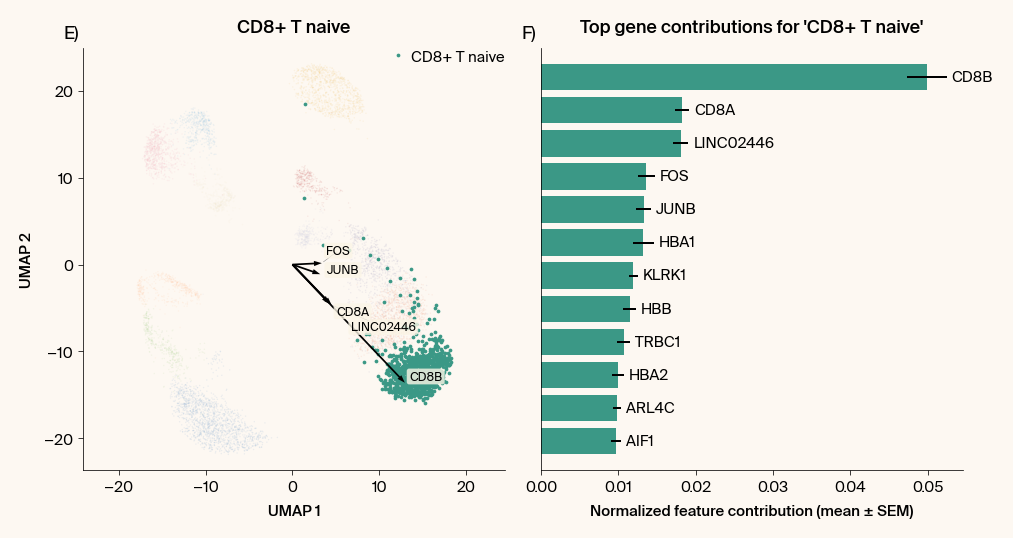

In [ ]:
# | label: fig-top-gene-features-one-type
# | layout-ncol: 1
# | fig-cap: "The top gene features for each cell type. Note that the largest feature vectors do not always point to the centroid, often indicating a gradient of importance for that feature across the cluster. Error bars are generated by normalizing the feature importance vectors for each cell by the distance to the centroid of the class for that UMAP fit to account for changing cluster centroids across fits. Note that most classes have only a few top features."
with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    top_genes_dict, mean_contributions_dict = plot_feature_importance_by_cell_type(
        all_run_jacobians=np.array(jacobxall_all),
        adata=adata,
        embedding=embedding,
        cell_type_plot=[2]
        # n_top_features=12
    )

    # You can now inspect the top genes for any cell type
    # print("\nTop genes for CD4+ T activated:")
    # print(top_genes_dict.get('CD4+ T activated'))

/tmp/ipython-input-2049284779.py:89: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



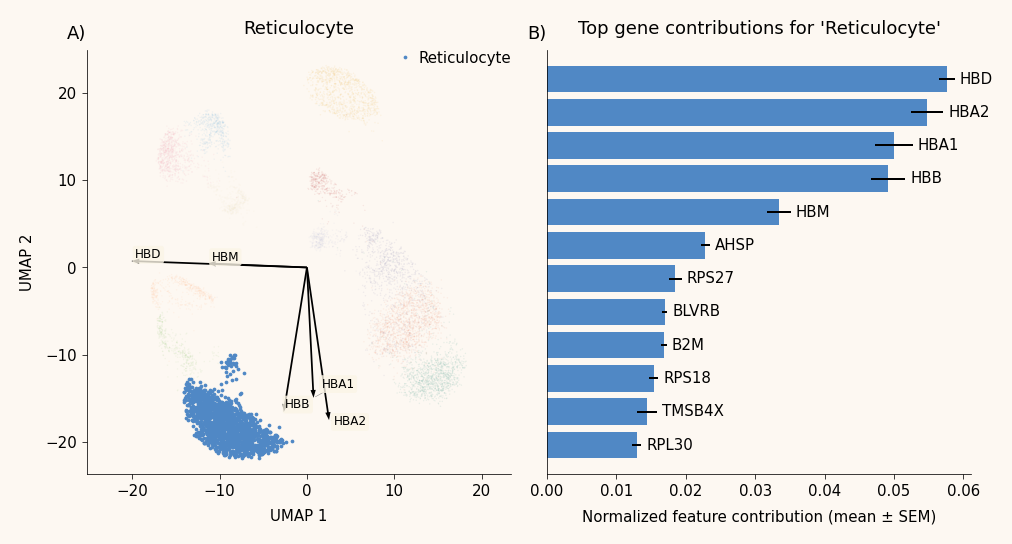

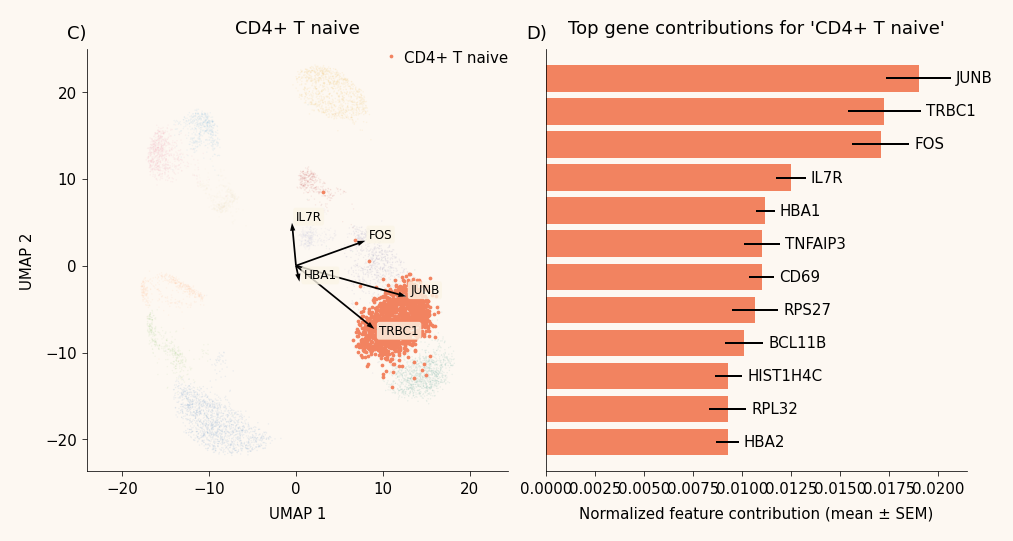

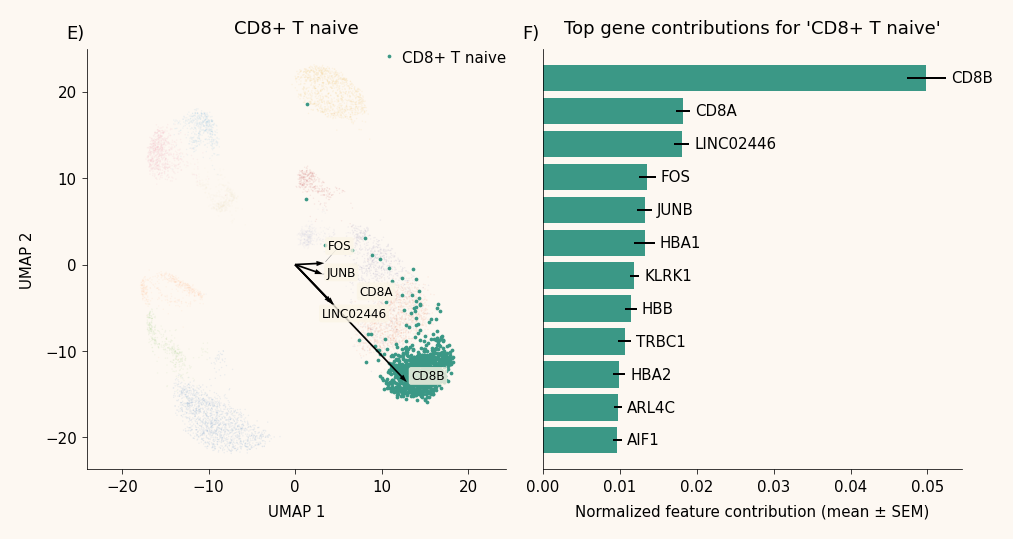

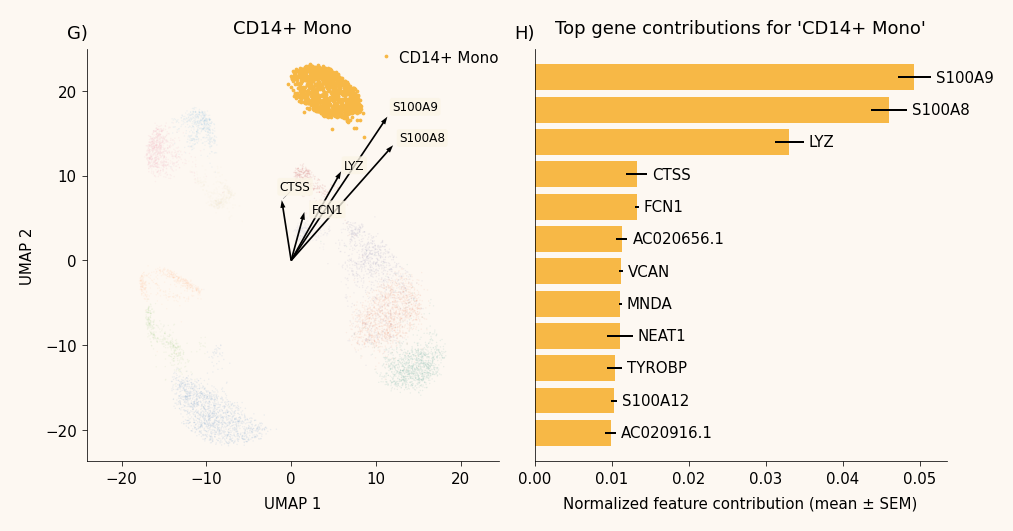

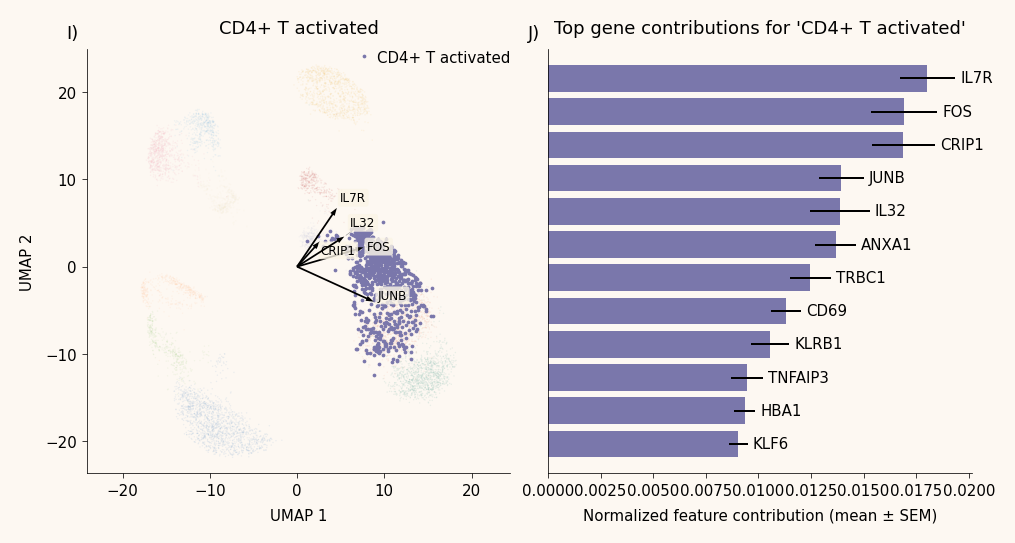

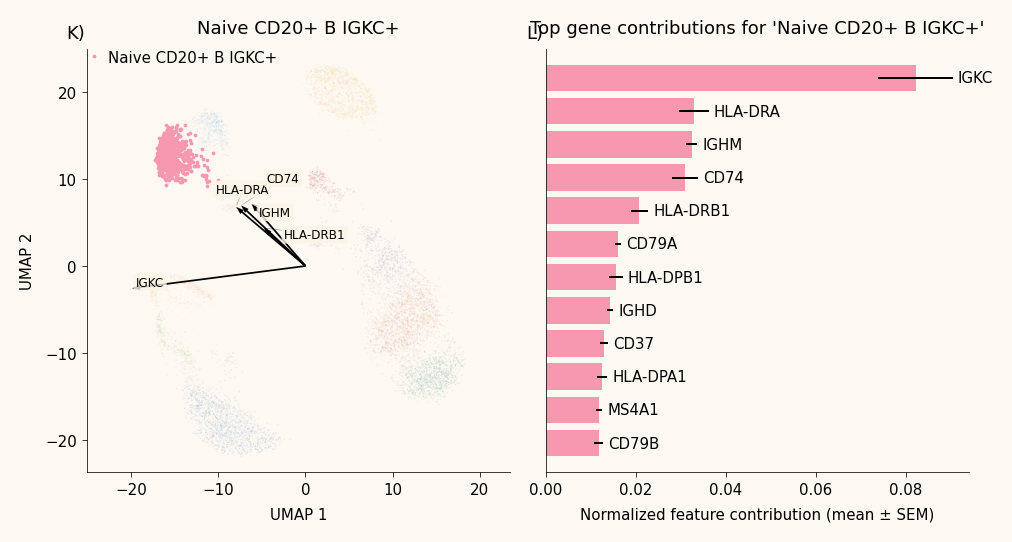

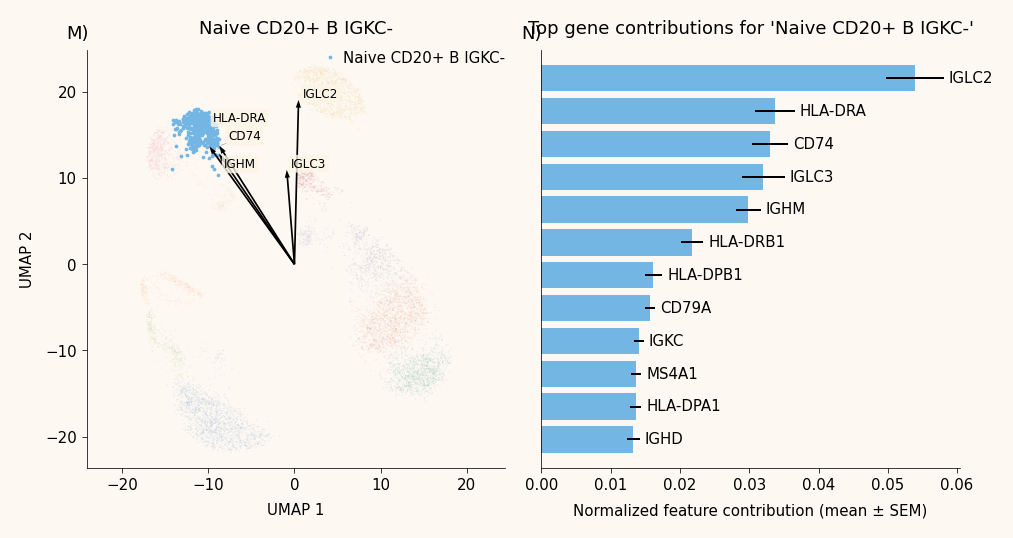

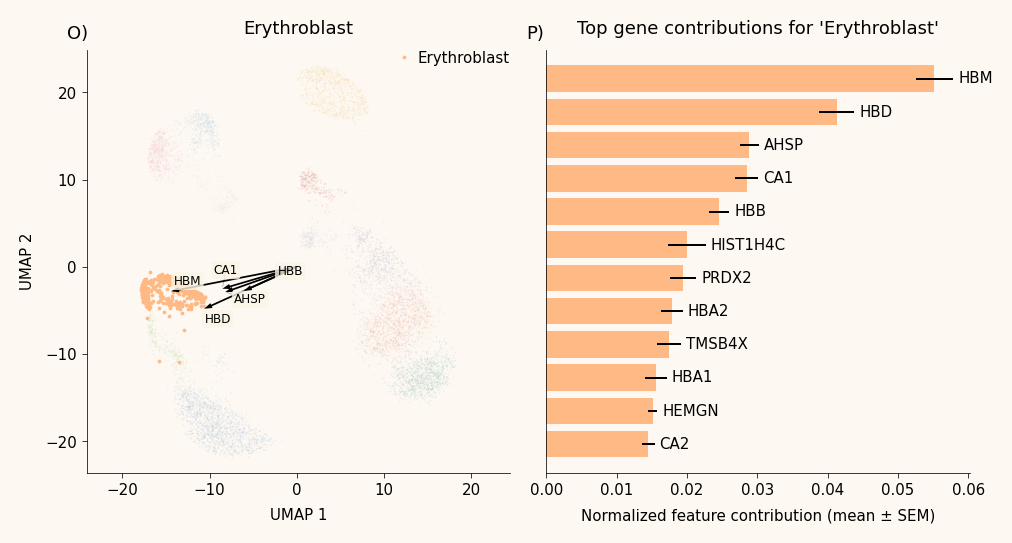

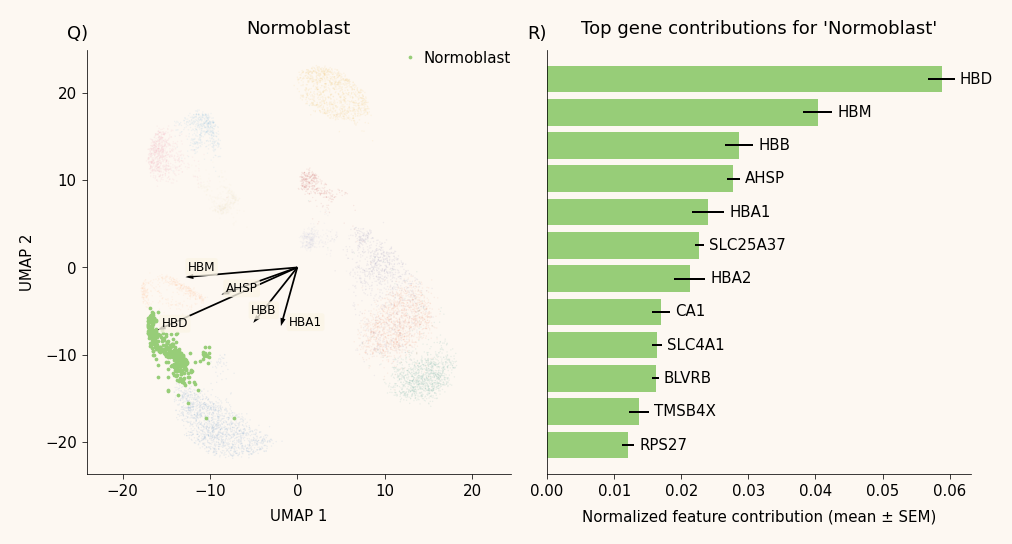

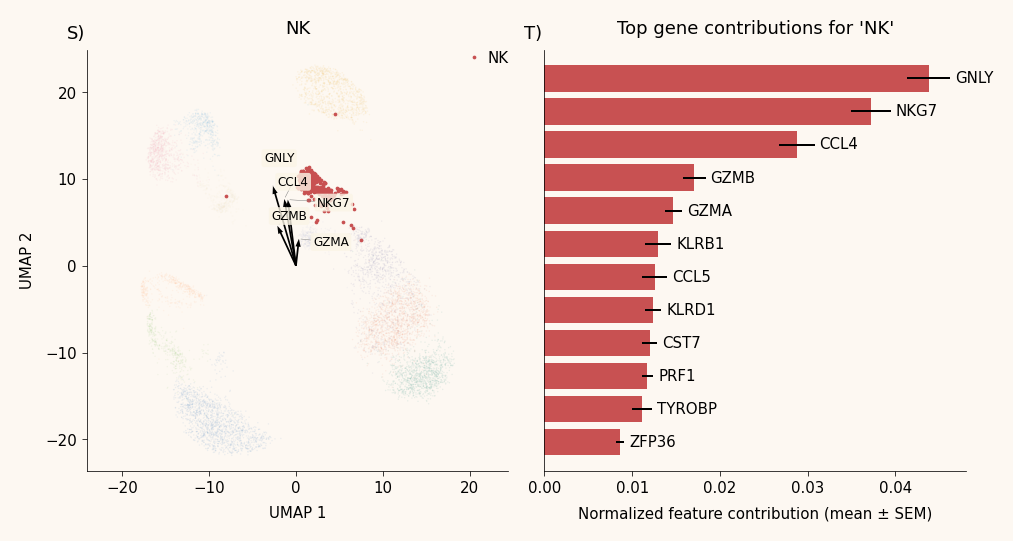

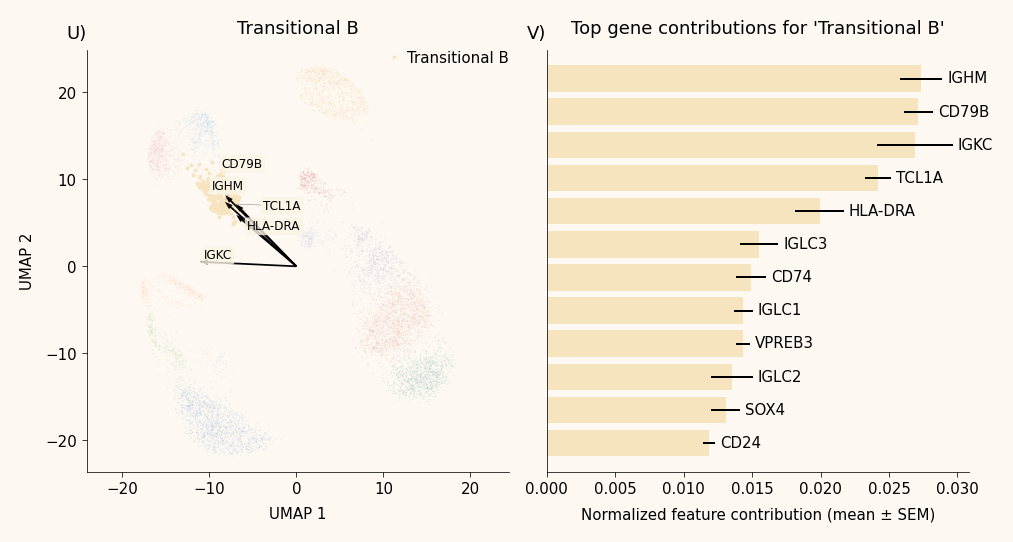

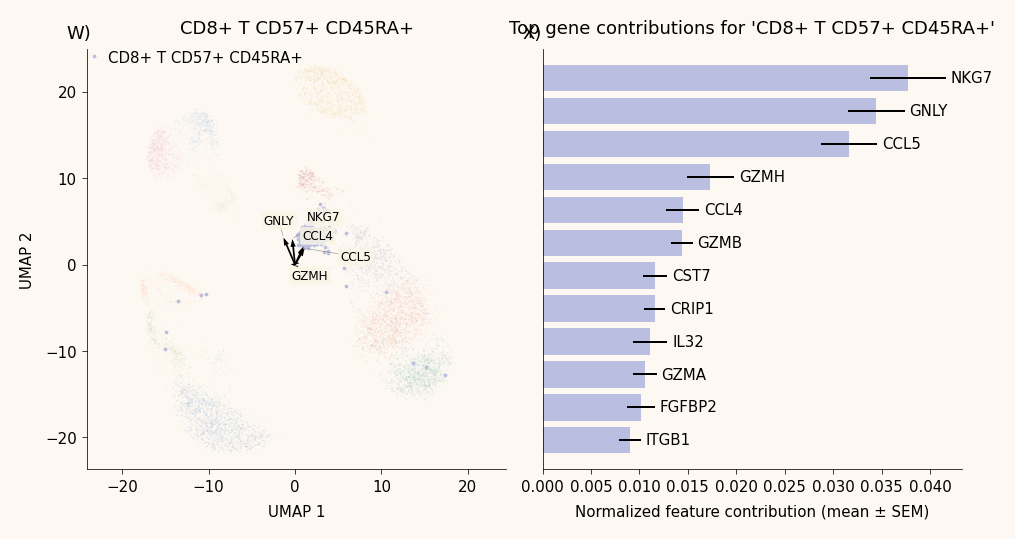

In [27]:
# | label: fig-top-gene-features-by-type
# | layout-ncol: 1
# | toggle: true
# | output-hidden: true
with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    top_genes_dict, mean_contributions_dict = plot_feature_importance_by_cell_type(
        all_run_jacobians=np.array(jacobxall_all),
        adata=adata,
        embedding=embedding,
        cell_type_plot= list(np.arange(12))
        # cell_type_plot=[ 0,  1],#  2,  3],#,  4,  5,  6,  7,  8,  9, 10, 11],
        # n_top_features=12
    )

### Dot plots
----

We can compare the features found by the Jacobian to differential expression.

we find that many of the features found by differential expression between cell types are not preserved in the Jacobian representation. 
This highlights how the Jacobian method provides a complementary view of the feature space to features from differential expression.

In [28]:
# | code-fold: true
#obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon", n_genes=2)

In [29]:
# | code-fold: true
#get feature contributions from normalized UMAP embedding contributions
dfindall=[]
dfinddict={}

n_features=2
for ti in adata.obs['cell_type'].value_counts().index[:]:
    # print(ti)
    topargs = np.argsort(mean_contributions_dict[ti])#[::-1][:8]
    dfind = topargs[::-1][:n_features]
    # print([genes[ii] for ii in dfind])
    dfinddict[ti]=[genes[ii] for ii in dfind if ii not in dfindall]
    dfindall.extend(dfind)
adata.layers['jacobian'] = genedist

In [30]:
# | code-fold: true
#build dictionary of combined gene features from diff exp and jacobian
from collections import defaultdict

diff_exp_dict = {
    cell_type: list(adata.uns['rank_genes_groups']['names'][cell_type])
    for cell_type in list(adata.uns['rank_genes_groups']['names'].dtype.names)
}

dd = defaultdict(list)
gall = []
for d in (dfinddict, diff_exp_dict): # you can list as many input dicts as you want here
    for key, value in d.items():
        # print(value)
        # if value not in gall:
        dd[key].extend([vi for vi in value if vi not in gall])
        gall.extend([vi for vi in value if vi not in gall])

/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_anndata.py:2074: FutureWarning:

Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.



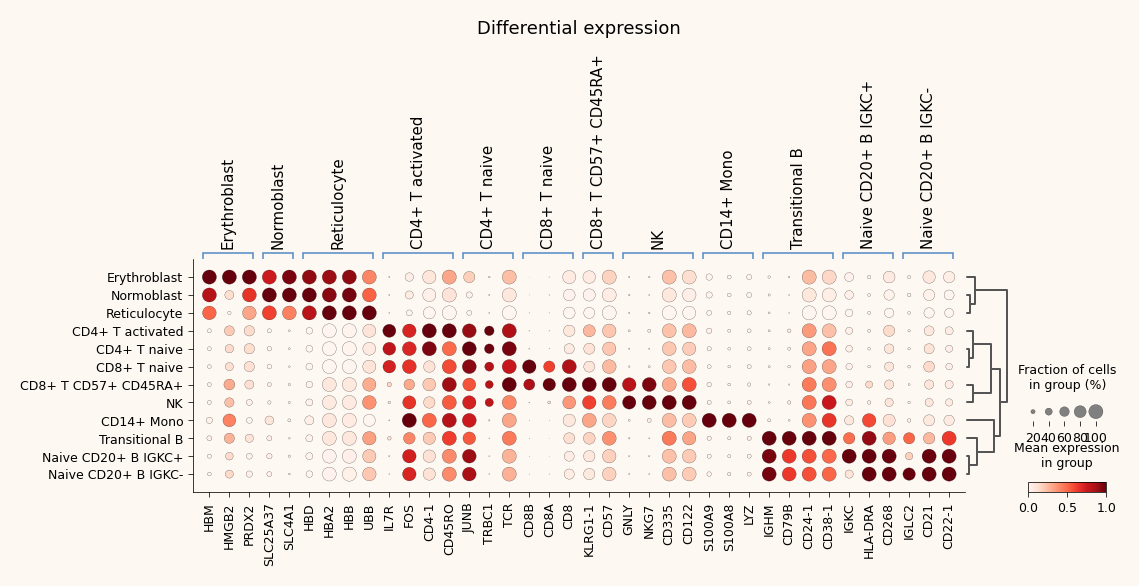

/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_anndata.py:2074: FutureWarning:

Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.



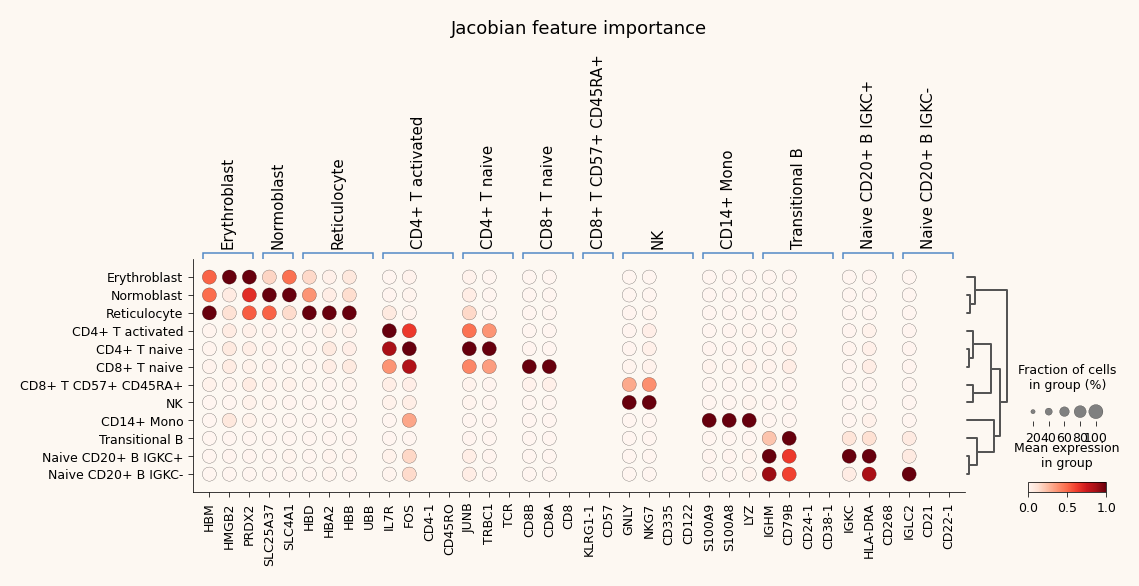

In [32]:
# | code-fold: true
# | label: fig-dotplot
# | layout-ncol: 1
# | fig-cap: "Dot plots for gene expression analysis."
# | fig-subcap: 
#       - "The dot plot for the top differential expression features by cell type."
#       - "The dot plot for the top differential Jacobian features by cell type."
#dotplot with jacobian features for marker genes

with mpl.rc_context({"figure.facecolor": apc.parchment,
                        "axes.facecolor": apc.parchment}):
    ax1=sc.pl.rank_genes_groups_dotplot(adata,var_names=dd, groupby='cell_type', standard_scale="var",show= False)#,title="Differential Expression")#, n_genes=8)#, expression_cutoff=.0001,)
    # ax1['mainplot_ax'].set_title()
    ax1['mainplot_ax'].set_title("Differential expression", y=1.9)
    plt.show()
    ax2=sc.pl.rank_genes_groups_dotplot(adata,var_names=dd, groupby='cell_type', layer='jacobian',standard_scale="var",show=False)#, title="Jacobian feature importance")#, expression_cutoff=.0001,)
    # ax2.set_title("Jacobian feature importance")

    ax2['mainplot_ax'].set_title("Jacobian feature importance", y=1.9)
    plt.show()

## Conclusion
----
This work demonstrates a novel approach to interpreting UMAP embeddings by leveraging glass box deep networks. We've shown how to overcome the traditional black box nature of nonlinear dimensionality reduction, specifically UMAP, by implementing a locally linear (but globally nonlinear) embedding function. This allows for the exact quantification of feature attributions for each data point in the UMAP embedding space, directly quantifying the contribution of individual genes to cell positions for scRNAseq data. This stands in contrast to conventional methods like differential expression, which provide only a proxy for what UMAP has learned.

## References
----

Chari, T., & Pachter, L. (2023). The specious art of single-cell genomics. PLOS Computational Biology, 19(8), e1011288.

Luecken, M. D., Burkhardt, D. B., Cannoodt, R., Lance, C., Agrawal, A., Aliee, H., ... & Bloom, J. M. (2021, August). A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. In Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2).

Mohan, S., Kadkhodaie, Z., Simoncelli, E. P., & Fernandez-Granda, C. (2019). Robust and interpretable blind image denoising via bias-free convolutional neural networks. arXiv preprint arXiv:1906.05478.

Wang, S., Mohamed, A. R., Caruana, R., Bilmes, J., Plilipose, M., Richardson, M., ... & Aslan, O. (2016, June). Analysis of deep neural networks with extended data jacobian matrix. In International Conference on Machine Learning (pp. 718-726). PMLR.
